In [69]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
import random

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_openml

# import custom module
from mnist_helpers import *


import math
import os
from sklearn import preprocessing
import sys

import cvxpy as cp
from multiprocessing import Process, Pipe

def init_dataset():
    # it creates mldata folder in your root project folder
    mnist = fetch_openml('mnist_784')
    mnist.keys()
    #data field is 70k x 784 array, each row represents pixels from 28x28=784 image
    images = mnist.data
    targets = mnist.target
    
    # Let's have a look at the random 16 images, 
    # We have to reshape each data row, from flat array of 784 int to 28x28 2D array

    #pick  random indexes from 0 to size of our dataset
    #show_some_digits(images,targets)
    
    #full dataset classification
    X_data = images/255.0
    Y = targets
    
    # change the porblem to binary classification problem
    y = []
    for i in Y:
        if i == '0':
            y.append(1)
        else:
            y.append(-1)
    y = np.array(y)

    print(X_data.shape)
    print(y.shape)
    
    return X_data, y, X_data, y

# Condition metric
def H(X, y, theta):
    y = y.reshape(y.shape[0], 1) # change to 2d array
    return (1 - y * (X@theta))

def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*(theta.T @ theta)
    loss = np.mean([max(0, i) for i in h])
    return np.asscalar(penalty) + np.asscalar(loss) 

def svm_grad_re(X, y, theta, lamda):
    h = H(X, y, theta)
    y = y.reshape(y.shape[0], 1) # change to 2d array
    cond = np.array([(i > 0)*1 for i in h])
    return 2*lamda*theta - X.T @ (y*cond)/y.shape[0]

def gradient_and_loss(A, b): #convenient

    bA = b[:, np.newaxis] * A

    def gradient(x):
        bAx = bA @ x
        mask = bAx < 1
        return -(mask @ bA)

    def loss(x):
        bAx = bA @ x
        mask = bAx < 1
        return mask.sum() - bAx @ mask

    return gradient, loss

def split_dataset(x_train, y_train, i_process, num_worker=10):
    num_data = len(y_train)
    num_per_data = num_data // num_worker #size of each dataset among each worker
    start_index = i_process * num_per_data
    end_index = num_per_data * (i_process + 1)
    x_data_worker = x_train[start_index:end_index, :]
    y_data_worker = y_train[start_index:end_index, np.newaxis]
    
    return x_data_worker, y_data_worker       



def run_worker(i_process, pipe, rho=1., lamda=1e-3):
    
    #split dataset
    x_data_worker, y_data_worker = split_dataset(x_train, y_train, i_process)
    m = x_data_worker.shape[0] #num_data of each worker
    n = x_train.shape[1] #dim for each data
    
    #print(x_data_worker.shape)
    #print(y_data_worker.shape)
    
    xbar = cp.Parameter(n, value=np.zeros(n))
    u = cp.Parameter(n, value=np.zeros(n))
    x = cp.Variable(n) #previous is 'beta', now is x <--> weight
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lamda
    
    loss = cp.sum( cp.pos(1 - cp.multiply(y_data_worker, (x_data_worker * x)[:, np.newaxis])))
    #loss = cp.sum(cp.pos(1 - cp.multiply(y_data_worker, (x_data_worker*x)[:, np.newaxis])))
    #loss = cp.sum(cp.pos(1 - cp.multiply(y_data_worker, x_data_worker*x[:, np.newaxis])))
    #loss = cp.sum(cp.pos(1 - cp.multiply(Y, (X*beta - v)[:, np.newaxis])))   
    #reg = cp.norm(x, 1)
    #fi = loss + lambd*reg
    #fi += (rho/2)*cp.sum_squares(x - xbar + u)
    #prox = cp.Problem(cp.Minimize(fi))
    
    # ADMM loop.
    while True:
        #f = loss + (rho/2)*cp.sum_squares(x - xbar + u)
        reg = cp.norm(x, 1)
        fi = loss/m + lambd*reg
        f = fi + (rho/2)*cp.sum_squares(x - xbar + u)/m
        prox = cp.Problem(cp.Minimize(f))
        
        prox.solve(scaling=0, polish=0, verbose=False)
        pipe.send(x.value)
        xbar.value = pipe.recv()
        u.value += x.value - xbar.value

        
        
def ADMM_v1(x_train, y_train, x_test, y_test, x_init, rho=1., lamda=1e-3,  max_iter=100, num_worker=10):
    start = time.process_time()
    num_of_disp = 10
    #setup the workers.
    pipes =[]
    procs =[]
    signal_T = np.zeros(max_iter)
    f_loss = np.zeros(max_iter)
    
    train_grad, train_loss = gradient_and_loss(x_train, y_train)
    
    for i_process in range(num_worker):
        local, remote = Pipe()
        pipes += [local]
        procs += [Process(target = run_worker, args=(i_process, remote, rho, lamda))]
        procs[-1].start()
        
    #ADMM loop
    for i in range(1, max_iter):
        # Gather and average xi
        xbar = sum(pipe.recv() for pipe in pipes) / num_worker
        #xbar = sum(quantize(pipe.recv(), method='None')[0] for pipe in pipes) / num_worker
        
        # Scatter xbar
        for pipe in pipes:
            pipe.send(xbar)
            
        f_loss[i] = train_loss(xbar) / x_train.shape[0]
        signal_T[i] += 2*num_worker*xbar.shape[0]    
    
        stop = time.process_time()
        duration = stop - start
        #print some info
        if (i % num_of_disp) == 0:
            print('ADMM: iter {}, current loss: {}, duration: {}'.format(i, f_loss[i], duration))

    [p.terminate() for p in procs]
    print('ADMM_v1 success.\t\n')
    
    return f_loss, signal_T, xbar


if __name__ == "__main__":
    #given para
    num_worker = 10
    max_iter = 40
    
    #init dataset and set train data
    x_train, y_train, x_test, y_test = init_dataset()
    N = x_train.shape[0] #num of datasets
    m_dim = x_train.shape[1] #num of dim.
  
    for var_lambda, var_rho in zip([1e-5], [5000.]):
        
        #initialize weights
        x_init = np.random.rand(m_dim)
        print('x_init: ', x_init.shape)
    
        #ADMM-based distributed learning
        #weight: x
        #loss of distirbuted: f_loss
        #commu. overhead: signal_T
        f_loss, signal_T, x = ADMM_v1(x_train, y_train, x_test, y_test, x_init, rho= var_rho, lamda= var_lambda, 
                                      max_iter= max_iter) #add quantization in the future version
    
        #run result in remote server
        #create data for plotting
        np.savetxt('f_loss_admm_{}_{}.txt'.format(var_lambda, var_rho), f_loss, delimiter= ' ')
        np.savetxt('signal_T_admm_{}_{}.txt'.format(var_lambda, var_rho), signal_T, delimiter= ' ')
        np.savetxt('x_admm_{}_{}.txt'.format(var_lambda, var_rho), x, delimiter= ' ')
    
    print('finish simulation')
    
    sys.exit(0)
    
    
    
    
    
    
    

(70000, 784)
(70000,)
x_init:  (784,)
ADMM: iter 10, current loss: 0.042311089990775354, duration: 5.23805399999992
ADMM: iter 20, current loss: 0.03567965123772084, duration: 10.207843999999795
ADMM: iter 30, current loss: 0.03296308692737158, duration: 15.190887999999859
ADMM_v1 success.	

finish simulation


SystemExit: 0

/Users/haoch/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
#plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#plot admm
l_admm_1 = np.loadtxt('f_loss_admm_1e-03_5000.0.txt')
l_admm_2 = np.loadtxt('f_loss_admm_1e-04_5000.0.txt')
l_admm_3 = np.loadtxt('f_loss_admm_1e-05_5000.0.txt')
x_axis = range(l_admm_1.shape[0])
print(l_admm_3.shape)

(40,)


In [8]:
l_admm_1 = l_admm_1*100
l_admm_2 = l_admm_2*100
l_admm_3 = l_admm_3*100

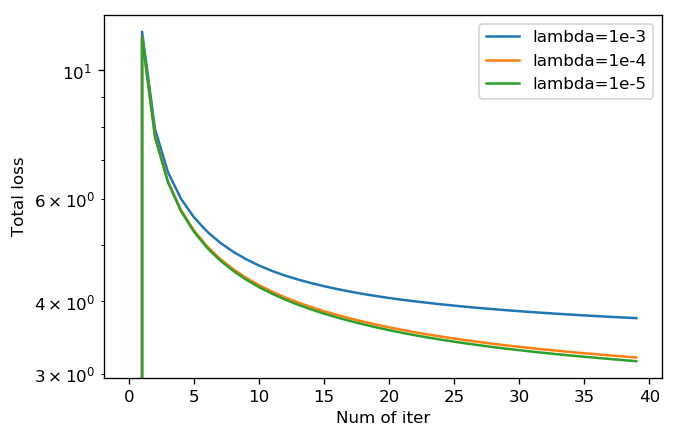

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

plt.semilogy(x_axis, l_admm_1, x_axis, l_admm_2, x_axis, l_admm_3)
plt.xlabel('Num of iter')
plt.ylabel('Total loss')
plt.legend(['lambda=1e-3', 'lambda=1e-4', 'lambda=1e-5'], loc='upper right')
#plt.savefig('CA5-b_ADMM_v2.png')

plt.show()